In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# class PlayerActions:
#     Left = 1
#     Right = 2
#     Jump = 4
#     Sprint = 8

In [3]:
from math import *

from numpy import sign


def load_vertical_data(
    name, file, scenario, minTimeStep, maxTimeStep, fromGround, fromWall
):
    df = load_latest_results(file, None)
    df = df[df["ScenarioName"] == scenario]
    df.index = df["TimeStep"]
    df.drop(columns=["TimeStep"], inplace=True)
    df = df.loc[minTimeStep:maxTimeStep]
    df.reset_index(inplace=True, drop=True)

    def filter_actions(actions):
        for action in actions:
            if action in ["Jump"]:
                yield action

    df["Actions"] = df["Actions"].apply(lambda x: list(filter_actions(x)))

    df.loc[0, "VelocityY"] = 0
    df.drop(df[df["VelocityY"] == -20].index[1:], inplace=True)
    df = df[["Actions", "VelocityY"]]

    return {"name": name, "fromGround": fromGround, "fromWall": fromWall, "data": df}


def load_horizontal_data(
    name,
    file,
    scenario,
    minTimeStep,
    maxTimeStep,
    fromWall,
    variable_length,
    reset_first_action=False,
):
    df: pd.DataFrame = load_latest_results(file, None)
    df = df[df["ScenarioName"] == scenario]
    df.index = df["TimeStep"]
    df.drop(columns=["TimeStep"], inplace=True)
    df = df.loc[minTimeStep:maxTimeStep]

    def filter_actions(actions):
        for action in actions:
            if action in ["Left", "Right", "Sprint"]:
                yield action

    df["Actions"] = df["Actions"].apply(lambda x: list(filter_actions(x)))

    df = df[["Actions", "VelocityX"]]
    df.reset_index(inplace=True, drop=True)

    if fromWall:
        df.loc[0, "VelocityX"] = 0
        # vx = df.loc[len(df) - 1, 'VelocityX']
        # if abs(vx) > 12.8:
        #     df.loc[len(df) - 1, 'VelocityX'] = 12.8 * sign(vx)

    if reset_first_action:
        df.loc[0, "Action"] = 0

    return {
        "name": name,
        "variable_length": variable_length,
        "data": df,
    }


def invert_horizontal_data(data):
    data = data.copy()
    data["data"] = data["data"].copy()
    data["name"] = (
        data["name"]
        .replace("Left", "XXX")
        .replace("Right", "Left")
        .replace("XXX", "Right")
    )
    data["data"]["VelocityX"] = data["data"]["VelocityX"] * -1

    def invert_actions(actions):
        for action in actions:
            if action == "Left":
                yield "Right"
            elif action == "Right":
                yield "Left"
            else:
                yield action

    data["data"]["Actions"] = data["data"]["Actions"].apply(
        lambda x: list(invert_actions(x))
    )

    # sprintPressed = ((data['data']['Action'] & PlayerActions.Sprint) == PlayerActions.Sprint).apply(lambda x: PlayerActions.Sprint if x else 0)
    # leftPressed = ((data['data']['Action'] & PlayerActions.Left) == PlayerActions.Left).apply(lambda x: PlayerActions.Right if x else 0)
    # rightPressed = ((data['data']['Action'] & PlayerActions.Right) == PlayerActions.Right).apply(lambda x: PlayerActions.Left if x else 0)
    # data['data']['Action'] = sprintPressed | leftPressed | rightPressed
    return data

In [4]:
from itertools import chain

vData = list(
    chain.from_iterable(
        [
            [
                load_vertical_data(
                    f"Ground|Jump{i}",
                    "VerticalGroundJumpAccelerationTests",
                    f"[Jump](001)_[Jump](0{i:02d})_[](036)",
                    0,
                    100,
                    True,
                    False,
                )
                for i in range(1, 21, 1)
            ],
            [
                load_vertical_data(
                    f"Wall|Jump{i}",
                    "VerticalWallJumpAccelerationTests",
                    f"[](010)_[Jump](0{i:02d})_[](036)",
                    10,
                    100,
                    True,
                    False,
                )
                for i in range(1, 17, 1)
            ],
        ]
    )
)


def saveVerticalData():
    def convertData(d):
        d = d.copy()
        d["data"] = d["data"].to_dict(orient="records")
        return d

    data = [convertData(d) for d in vData]
    json.dump(data, open("GeneratedData/vData.json", "w"), indent=4)


saveVerticalData()
# json.dump(vData, open('data/vData.json', 'w'), indent=4)

In [5]:
# load_latest_results('HorizontalAirStopTests', None)['ScenarioName'].unique()
load_horizontal_data(
    "",
    "HorizontalWallJumpAccelerationTests",
    "[](010)_[Jump,Right,Sprint](001)_[Left](001)_[Left,Sprint](036)",
    10,
    36,
    fromWall=False,
    variable_length=False,
)

{'name': '',
 'variable_length': False,
 'data':    Actions           VelocityX
 0   [Right, Sprint]   0.00000 
 1            [Left]  12.80000 
 2    [Left, Sprint]   8.00122 
 3    [Left, Sprint]   7.13325 
 4    [Left, Sprint]   6.26528 
 5    [Left, Sprint]   5.39730 
 6    [Left, Sprint]   4.52933 
 7    [Left, Sprint]   3.66136 
 8    [Left, Sprint]   2.79339 
 9    [Left, Sprint]   1.92541 
 10   [Left, Sprint]   1.05744 
 11   [Left, Sprint]   0.18947 
 12   [Left, Sprint]  -0.67850 
 13   [Left, Sprint]  -1.54648 
 14   [Left, Sprint]  -2.41445 
 15   [Left, Sprint]  -3.28242 
 16   [Left, Sprint]  -4.15039 
 17   [Left, Sprint]  -5.01836 
 18   [Left, Sprint]  -5.88634 
 19   [Left, Sprint]  -6.75431 
 20   [Left, Sprint]  -7.62228 
 21   [Left, Sprint]  -8.49025 
 22   [Left, Sprint]  -9.35823 
 23   [Left, Sprint] -10.22620 
 24   [Left, Sprint] -11.09417 
 25   [Left, Sprint] -11.96214 
 26   [Left, Sprint] -12.80195 }

In [6]:
hData = [
    load_horizontal_data(
        "Ground|Stop->Stop",
        "HorizontalGroundAccelerationTests",
        "[](005)_[Right](020)",
        0,
        0,
        fromWall=False,
        variable_length=True,
        reset_first_action=True,
    ),
    load_horizontal_data(
        "Ground|Stop->Right,Sprint",
        "HorizontalGroundAccelerationTests",
        "[](005)_[Right,Sprint](020)",
        5,
        22,
        fromWall=False,
        variable_length=False,
    ),
    load_horizontal_data(
        "Ground|Right,Sprint->Right,Sprint",
        "HorizontalGroundAccelerationTests",
        "[](005)_[Right,Sprint](020)",
        22,
        22,
        fromWall=False,
        variable_length=True,
    ),
    load_horizontal_data(
        "Ground|Right,Sprint->Stop",
        "HorizontalGroundAccelerationTests",
        "[Right,Sprint](005)_[](020)",
        5,
        9,
        fromWall=False,
        variable_length=False,
    ),
    load_horizontal_data(
        "Ground|Right,Sprint->Left,Sprint",
        "HorizontalGroundTurnaroundAccelerationTests",
        "[Right,Sprint](005)_[Left,Sprint](036)",
        5,
        26,
        fromWall=False,
        variable_length=False,
    ),
    load_horizontal_data(
        "Air|Right,Stop->Right,Stop",
        "HorizontalAirStopTests",
        "[Jump,Right,Sprint](030)_[Left](002)_[Left,Sprint](007)_[Left](001)_[](010)_[Right,Sprint](030)",
        40,
        40,
        fromWall=False,
        variable_length=True,
        reset_first_action=True,
    ),
    load_horizontal_data(
        "Air|Right,Stop->Right,Sprint",
        "HorizontalAirStopTests",
        "[Jump,Right,Sprint](030)_[Left](002)_[Left,Sprint](007)_[Left](001)_[](010)_[Right,Sprint](030)",
        50,
        72,
        fromWall=False,
        variable_length=False,
    ),
    load_horizontal_data(
        "Air|Right,Sprint->Right,Sprint",
        "HorizontalAirStopTests",
        "[Jump,Right,Sprint](030)_[Left](002)_[Left,Sprint](007)_[Left](001)_[](010)_[Right,Sprint](030)",
        72,
        72,
        fromWall=False,
        variable_length=True,
    ),
    load_horizontal_data(
        "Air|Right,Sprint->Right,Stop",
        "HorizontalAirStopTests",
        "[Jump,Right,Sprint](030)_[Left](002)_[Left,Sprint](007)_[Left](001)_[](010)_[Right,Sprint](030)",
        30,
        40,
        fromWall=False,
        variable_length=False,
    ),
    load_horizontal_data(
        "Air|Right,Sprint->Left,Sprint",
        "HorizontalAirTurnaroundAccelerationTests",
        "[Jump,Right,Sprint](030)_[Left](001)_[Left,Sprint](036)",
        30,
        56,
        fromWall=False,
        variable_length=False,
    ),
    load_horizontal_data(
        "WallJump|Right,Sprint",
        "HorizontalWallJumpAccelerationTests",
        "[](010)_[Jump,Right,Sprint](030)",
        10,
        12,
        fromWall=True,
        variable_length=False,
    ),
]

hData.extend([invert_horizontal_data(data) for data in hData])

hData = {data["name"]: data for data in hData}

print(len(hData))

21


In [15]:
def create_hData_series(fromGround, fromWall, jumping, data):
    return {
        "fromGround": fromGround,
        "fromWall": fromWall,
        "jumping": jumping,
        "data": data,
    }


groundhSeries = [
    # ground accelerations
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=False,
        data=[
            hData["Ground|Stop->Right,Sprint"],
            hData["Ground|Right,Sprint->Right,Sprint"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=False,
        data=[
            hData["Ground|Right,Sprint->Right,Sprint"],  # variable length
            hData["Ground|Right,Sprint->Stop"],
        ],
    ),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=False,
        data=[
            hData["Ground|Right,Sprint->Right,Sprint"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=False,
        data=[
            hData["Ground|Right,Sprint->Left,Sprint"],
            hData["Ground|Left,Sprint->Left,Sprint"],  # variable length
        ],
    ),
]

airhSeries = [
    # ground jump accelerations
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=True,
        data=[
            hData["Ground|Stop->Stop"],  # variable length
            hData["Air|Right,Stop->Right,Sprint"],
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=True,
        data=[
            hData["Ground|Stop->Stop"],  # variable length
            hData["Air|Right,Stop->Right,Sprint"],
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
            hData["Air|Right,Sprint->Right,Stop"],
            hData["Air|Right,Stop->Right,Stop"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=True,
        data=[
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
            hData["Air|Right,Sprint->Right,Stop"],
            hData["Air|Right,Stop->Right,Stop"],  # variable length
        ],
    ),
    # create_hData_series(fromGround=True, fromWall=False, jumping=True, data=[
    #     hData['Air|Right,Sprint->Right,Sprint'],         # variable length
    #     hData['Air|Right,Sprint->Right,Stop'],
    #     hData['Air|Right,Stop->Right,Stop'],             # variable length
    #     hData['Air|Right,Stop->Right,Sprint'],
    #     hData['Air|Right,Sprint->Right,Sprint'],         # variable length
    # ]),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=True,
        data=[
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=True,
        data=[
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
            hData["Air|Right,Sprint->Left,Sprint"],
            hData["Air|Left,Sprint->Left,Sprint"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=True,
        fromWall=False,
        jumping=True,
        data=[
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
            hData["Air|Right,Sprint->Left,Sprint"],
            hData["Air|Left,Sprint->Left,Sprint"],  # variable length
            hData["Air|Left,Sprint->Left,Stop"],
            hData["Air|Left,Stop->Left,Stop"],  # variable length
        ],
    ),
]

wallhSeries = [
    # wall jumps
    create_hData_series(
        fromGround=False,
        fromWall=True,
        jumping=True,
        data=[
            hData["WallJump|Right,Sprint"],
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=False,
        fromWall=True,
        jumping=True,
        data=[
            hData["WallJump|Right,Sprint"],
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
            hData["Air|Right,Sprint->Right,Stop"],
            hData["Air|Right,Stop->Right,Stop"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=False,
        fromWall=True,
        jumping=True,
        data=[
            hData["WallJump|Right,Sprint"],
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
            hData["Air|Right,Sprint->Left,Sprint"],
            hData["Air|Left,Sprint->Left,Sprint"],  # variable length
        ],
    ),
    create_hData_series(
        fromGround=False,
        fromWall=True,
        jumping=True,
        data=[
            hData["WallJump|Right,Sprint"],
            hData["Air|Right,Sprint->Right,Sprint"],  # variable length
            hData["Air|Right,Sprint->Left,Sprint"],
            hData["Air|Left,Sprint->Left,Sprint"],  # variable length
            hData["Air|Left,Sprint->Left,Stop"],
            hData["Air|Left,Stop->Left,Stop"],  # variable length
        ],
    ),
]

# create_hData_series(fromGround=False, fromWall=True, jumping=True, data=[
#     hData['Wall->Right,Sprint'],
#     hData['Right,Sprint->Right,Sprint'],
# ])


def saveHorizontalData():
    data = []

    for d in hData.values():
        copy = d.copy()
        copy['data'] = copy['data'].to_dict(orient='records')
        data.append(copy)

    json.dump(data, open("GeneratedData/hData.json", "w"), indent=4)


def saveHorizontalDataSeries():
    def invert_actions(actions):
        for action in actions:
            if action == "Left":
                yield "Right"
            elif action == "Right":
                yield "Left"
            else:
                yield action

    def convertData(d, invert):
        # d = d.copy()
        d = d["data"].copy()
        if invert:
            d["VelocityX"] *= -1
            d["Actions"] = d["Actions"].apply(lambda x: list(invert_actions(x)))

        return {"data": d.to_dict(orient="records")}

    def convertSeries(s, invert):
        index = 0
        title = ""
        for d in s["data"]:
            name = (
                d["name"]
                .replace("Ground|", "")
                .replace("WallJump|", "")
                .replace("Air|", "")
            )
            name_parts = name.split("->")
            if index == 0:
                title = name_parts[0]
            if len(name_parts) > 1:
                title += "->" + name_parts[1]
            index += 1

        if invert:
            title = (
                title.replace("Right", "XXX")
                .replace("Left", "Right")
                .replace("XXX", "Left")
            )

        return {
            "name": title,
            "fromGround": s["fromGround"],
            "fromWall": s["fromWall"],
            "jumping": s["jumping"],
            "data": [convertData(d, invert) for d in s["data"]],
        }

    hSeries = groundhSeries + airhSeries + wallhSeries
    # hSeries = np.append(np.append(groundhSeries, airhSeries), wallhSeries)

    series = list(
        chain.from_iterable(
            [
                [convertSeries(s, False) for s in hSeries],
                [convertSeries(s, True) for s in hSeries],
            ]
        )
    )

    json.dump(series, open("GeneratedData/hDataSeries.json", "w"), indent=4)


saveHorizontalData()
saveHorizontalDataSeries()

In [8]:
def plot_data(horizontalData, verticalData=None, fill_variable_length=5):
    index = 0
    title = ""

    def getVY():
        return (
            [index]
            if verticalData is None
            else verticalData["VelocityY"][min(index, len(verticalData) - 1)]
        )

    data = []

    # materialize data ---------------------------------------------------------
    for hData in horizontalData["data"]:

        name = hData["name"].replace("Ground|", "").replace("WallJump|", "").replace("Air|", "")
        name_parts = name.split("->")
        if index == 0:
            title = name_parts[0]
        if len(name_parts) > 1:
            title += "->" + name_parts[1]

        (vX, vY) = ([], [])
        if hData["variable_length"]:
            for i in range(fill_variable_length):
                vX.append(hData["data"]["VelocityX"].values[0])
                vY.append(getVY())
                index += 1
        else:
            for i in range(len(hData["data"])):
                vX.append(hData["data"]["VelocityX"].values[i])
                vY.append(getVY())
                index += 1

        data.append(
            {
                "vX": np.array(vX),
                "vY": np.array(vY),
                "variable_length": hData["variable_length"],
            }
        )

    if index < 0 if verticalData is None else len(verticalData):
        (vX, vY) = ([], [])
        for i in range(len(verticalData) - index):
            vX.append(horizontalData["data"][-1]["data"]["VelocityX"].values[-1])
            vY.append(getVY())
        data.append(
            {
                "vX": np.array(vX),
                "vY": np.array(vY),
                "variable_length": True,
            }
        )

    # plot data ---------------------------------------------------------------
    (x, y) = ([], [])
    for d in data:
        vLength = d["variable_length"]
        color = "#ff0000" if not vLength else "#4488AA"
        line = "--" if vLength else "-"
        lastX = x[-1] if len(x) > 0 else 0
        lastY = y[-1] if len(y) > 0 else 0
        posX = np.concatenate([[lastX], (lastX + (d["vX"].cumsum() / 60))])
        posY = np.concatenate([[lastY], (lastY + (d["vY"].cumsum() / 60))])
        plt.plot(posX, posY, color=color, linestyle=line)
        x.extend(posX)
        y.extend(posY)

    plt.annotate(
        "",
        (x[-1], y[-1]),
        (x[-2], y[-2]),
        arrowprops=dict(color=color, arrowstyle="->", linewidth=2),
    )
    plt.plot(0, 0, "o", color="black")
    plt.xlabel("PositionX")
    plt.ylabel("PositionY" if verticalData is not None else "Time")
    plt.title(title)
    plt.grid()
    plt.show()

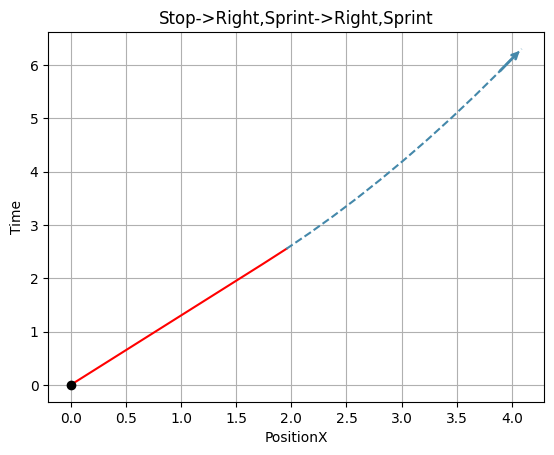

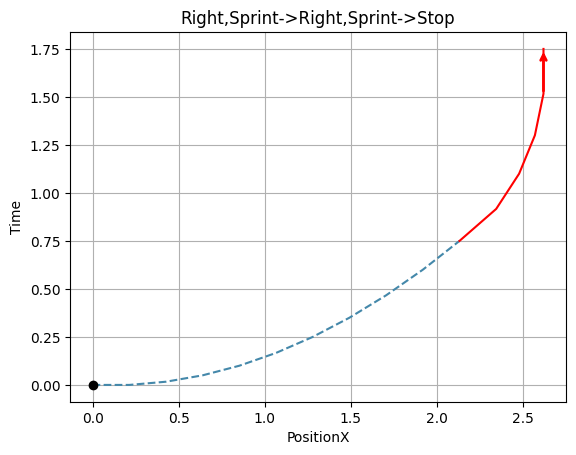

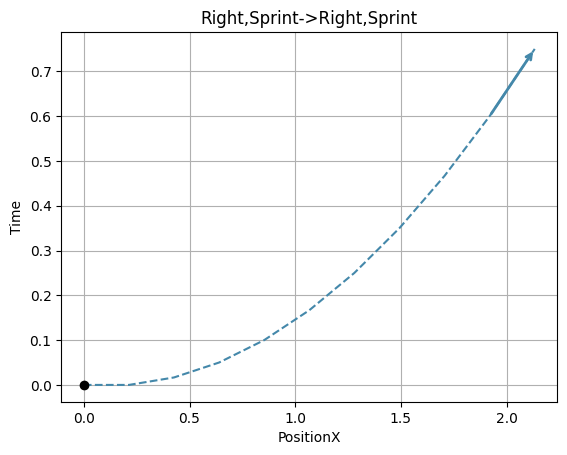

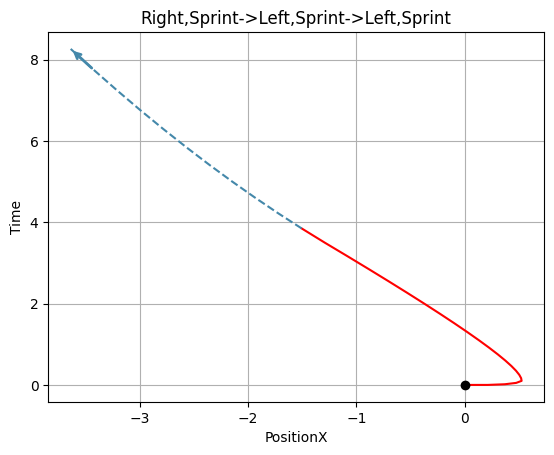

In [9]:
for i in range(0, len(groundhSeries)):
    plot_data(groundhSeries[i], None, 10)

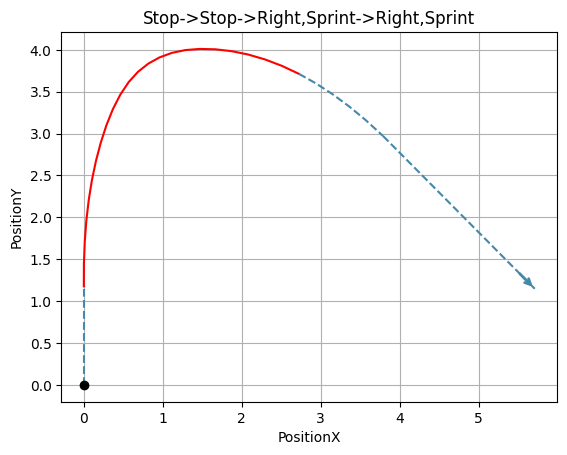

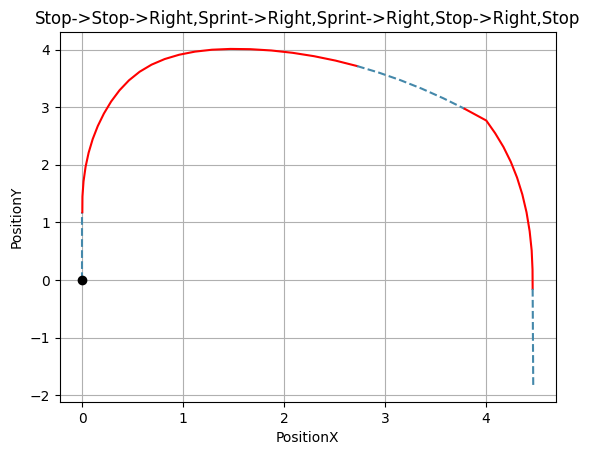

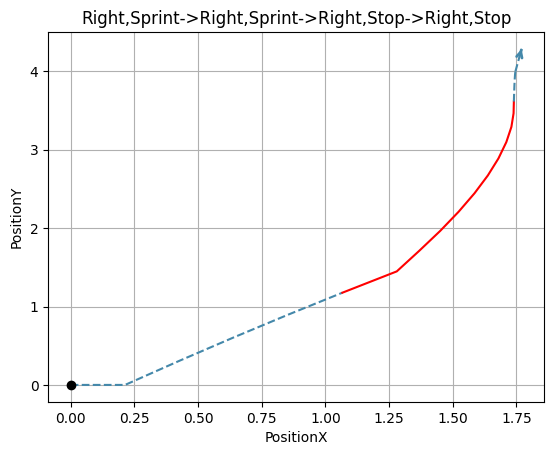

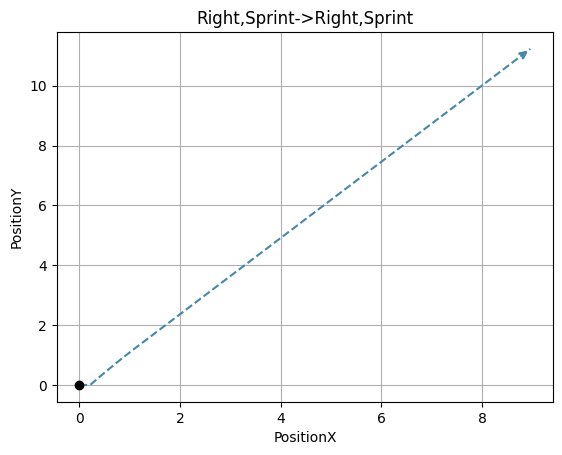

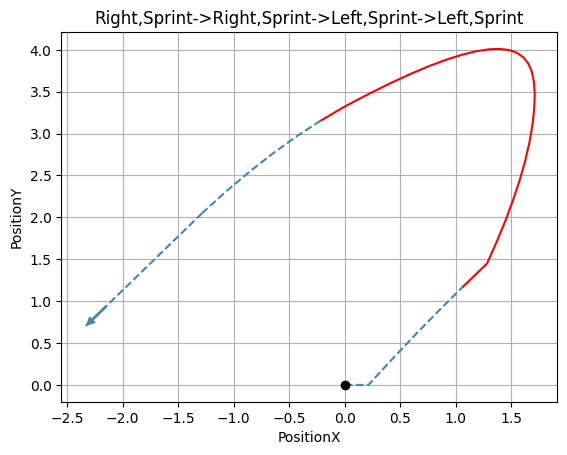

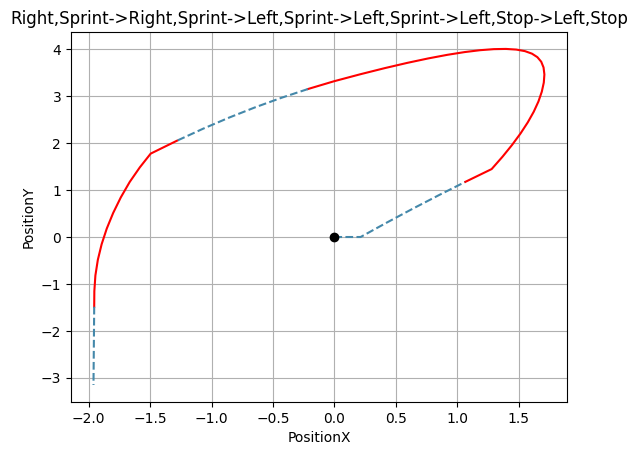

In [10]:
for i in range(0, len(airhSeries)):
    plot_data(airhSeries[i], vData[10]["data"], 5)

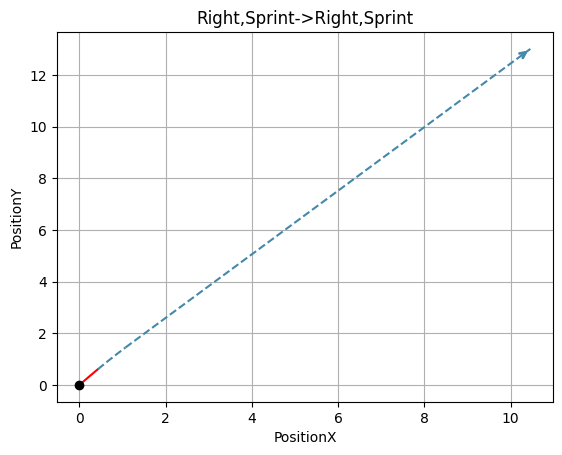

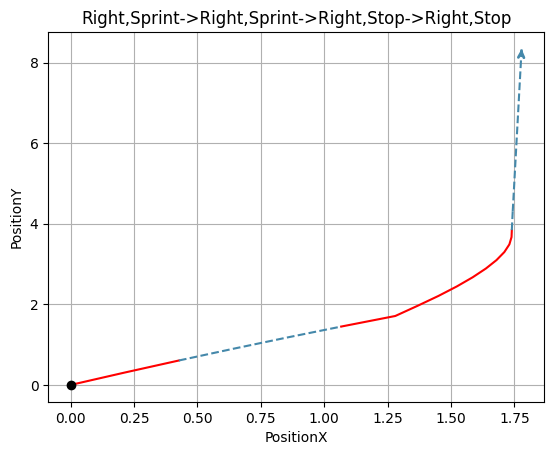

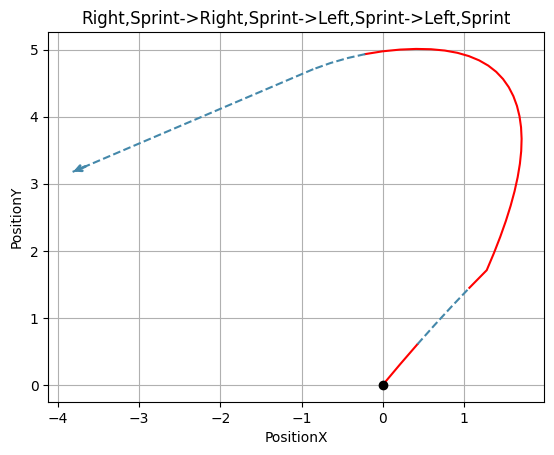

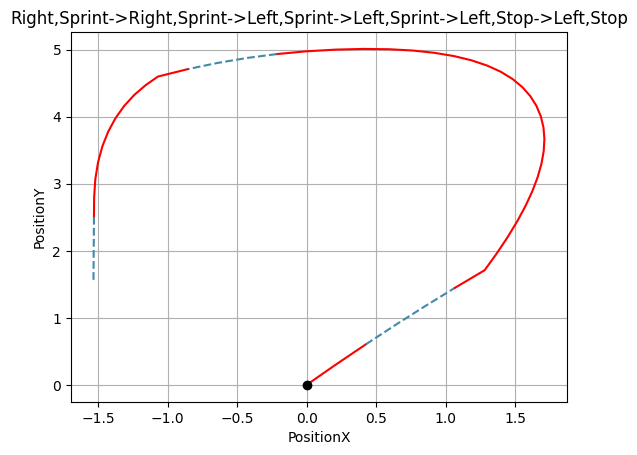

In [11]:
for i in range(0, len(wallhSeries)):
    plot_data(wallhSeries[i], vData[17]["data"], 3)